In [3]:
# Load in packages and data
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from typing import Tuple, List, Dict, Optional

from pathlib import Path

cwd = Path.cwd()

ll_df_cph = pd.read_csv(cwd / 'll_data' / 'll_cph.csv')
ll_df_aarhus = pd.read_csv(cwd / 'll_data' / 'll_aarhus.csv')
ll_df_odense = pd.read_csv(cwd / 'll_data' / 'll_odense.csv')

df_list = [ll_df_cph, ll_df_aarhus, ll_df_odense]
county_names = ['københavn', 'århus', 'odense']

/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_72812/3333189222.py:15: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  ll_df_cph = pd.read_csv(cwd / 'll_data' / 'll_cph.csv')


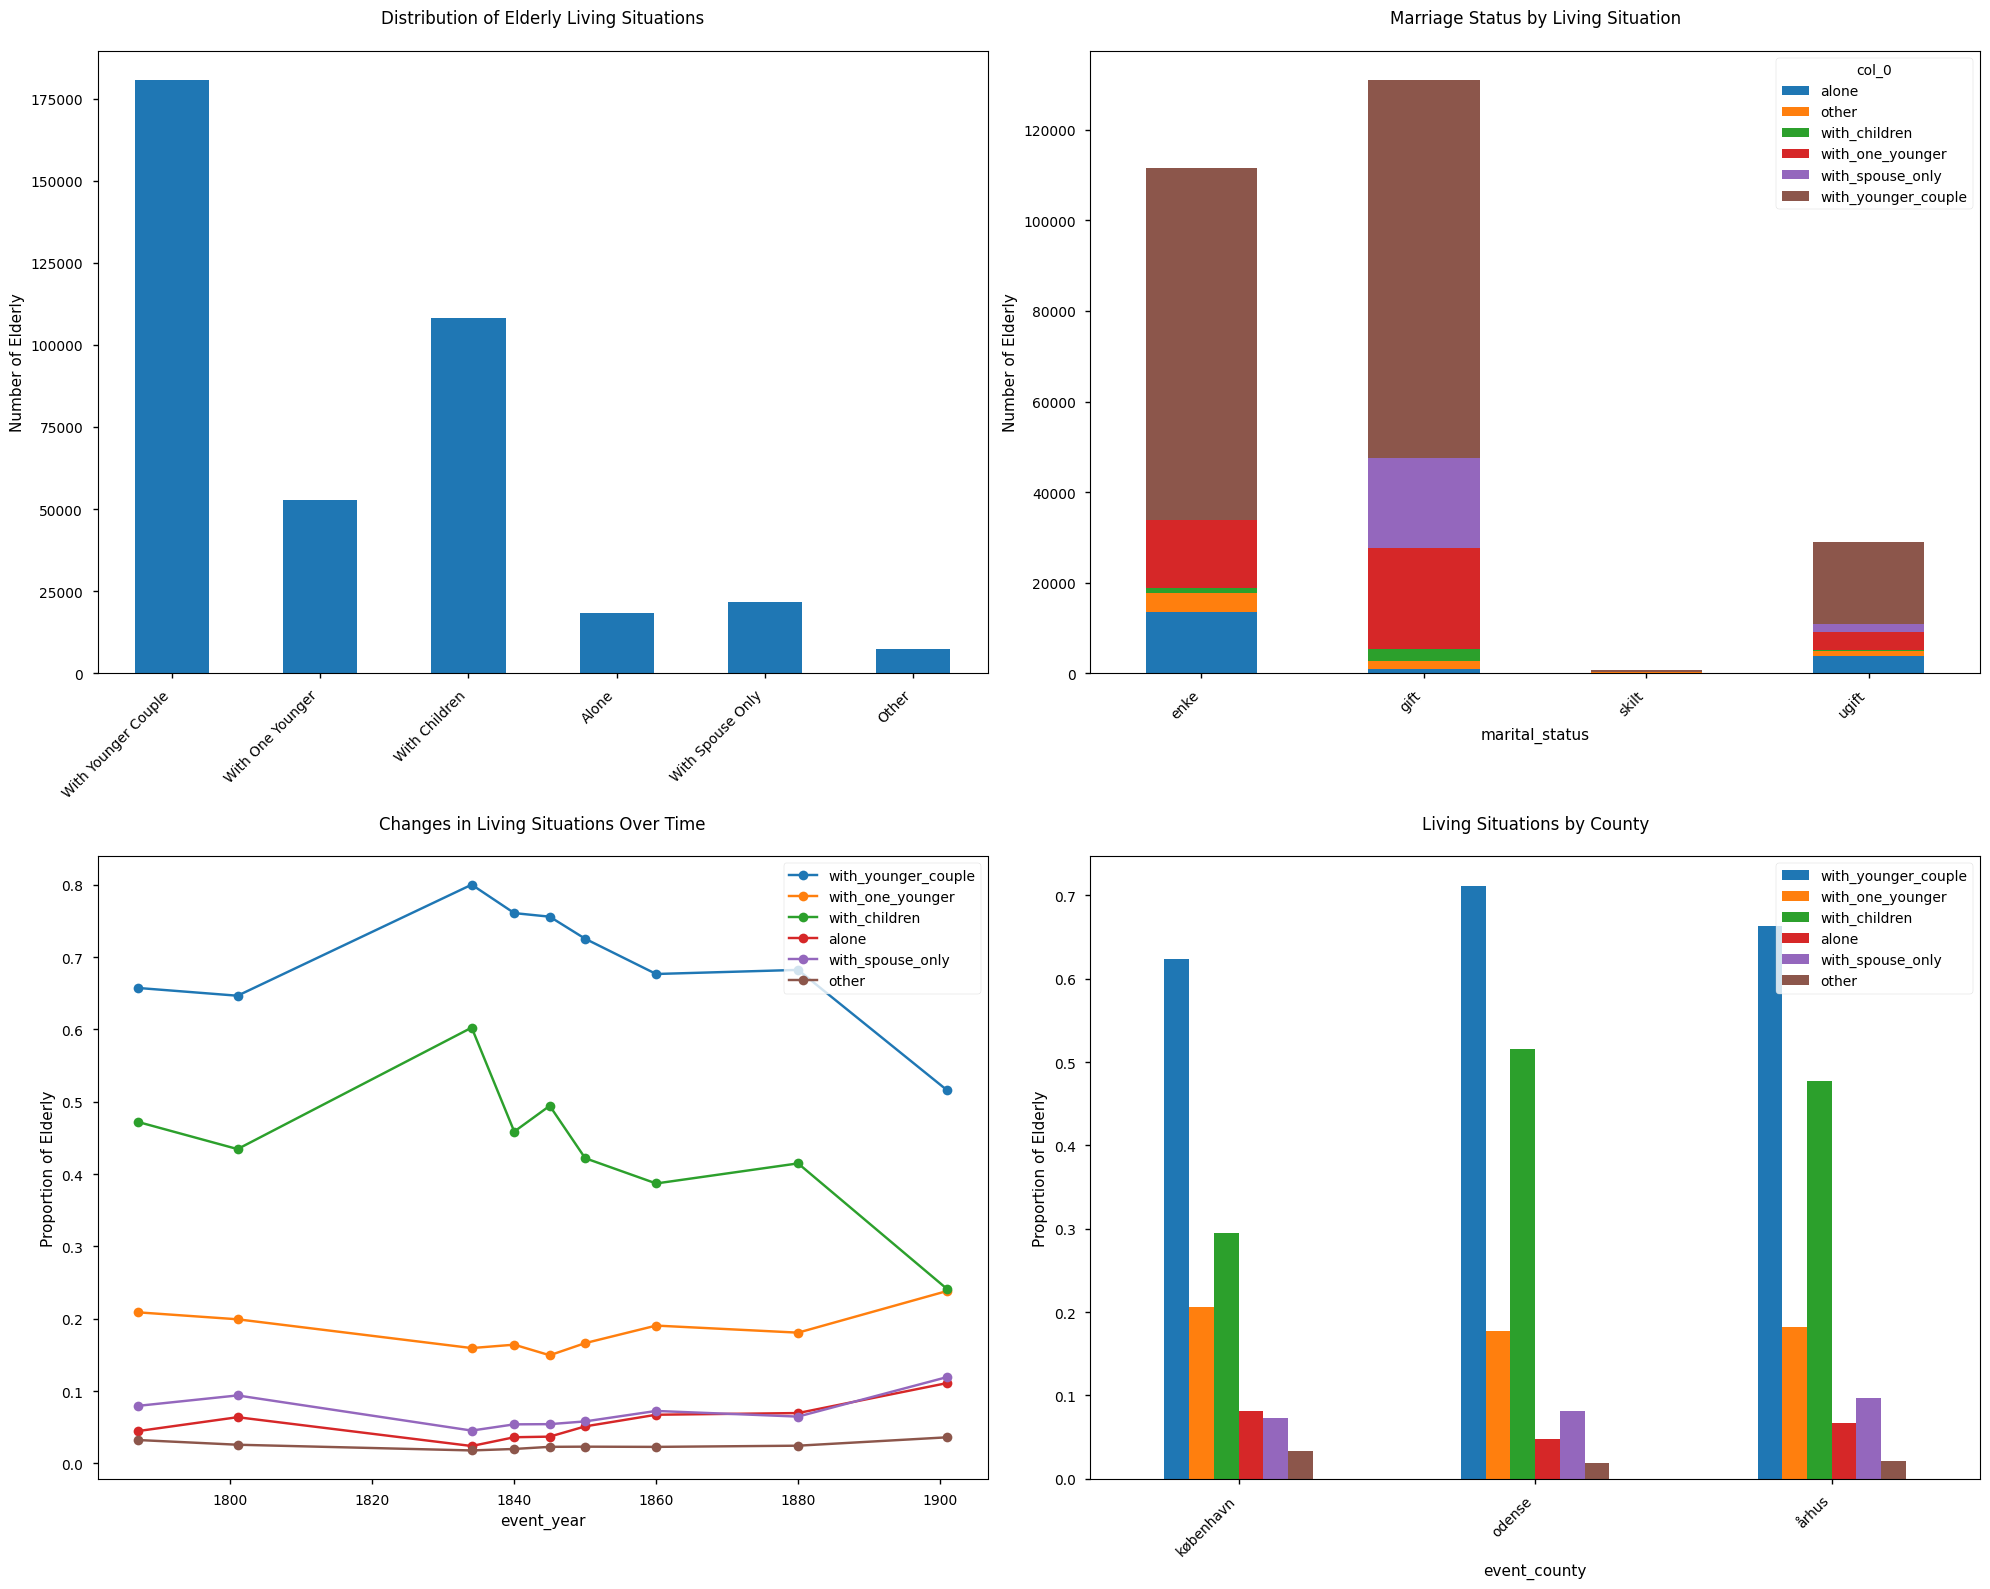


Summary Statistics:
--------------------------------------------------

Total number of elderly individuals: 273707

Distribution of living situations:
With Younger Couple: 180,588 (66.0%)
With One Younger: 52,756 (19.3%)
With Children: 108,349 (39.6%)
Alone: 18,467 (6.7%)
With Spouse Only: 21,630 (7.9%)
Other: 7,348 (2.7%)

Marriage status distribution:
marital_status
gift     48.1
enke     41.0
ugift    10.6
skilt     0.3
Name: proportion, dtype: float64


In [4]:
from typing import Dict, List, Tuple
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass

@dataclass
class ElderlyLivingSituation:
    """
    Dataclass to store information about elderly living situations.
    
    Attributes:
        with_younger_couple: Living with a younger married couple
        with_one_younger: Living with one younger person (age > 15)
        with_children: Living with children (age < 15)
        alone: Living alone
        with_spouse_only: Living alone with spouse
        other: Other living situations not covered above
    """
    with_younger_couple: bool = False
    with_one_younger: bool = False
    with_children: bool = False
    alone: bool = False
    with_spouse_only: bool = False
    other: bool = False

def analyze_elderly_household(
    household_df: pd.DataFrame,
    elderly_threshold: int = 60
) -> Dict[int, ElderlyLivingSituation]:
    """
    Analyzes the living situation for elderly people in a household.
    
    Args:
        household_df: DataFrame containing one household
        elderly_threshold: Age threshold for considering someone elderly
        
    Returns:
        Dictionary mapping elderly person IDs to their living situation
    """
    # Get elderly people in household
    elderly = household_df[household_df['age'] >= elderly_threshold]
    if elderly.empty:
        return {}
    
    # Get other household members
    others = household_df[household_df['age'] < elderly_threshold]
    
    # Initialize results
    results = {row['pa_id']: ElderlyLivingSituation() 
              for _, row in elderly.iterrows()}
    
    # Count household members
    n_household = len(household_df)
    n_elderly = len(elderly)
    
    # Check if any younger married couples
    younger_married = others[others['marital_status'].str.contains('gift', 
                                                                 case=False, 
                                                                 na=False)]
    has_younger_couple = len(younger_married) >= 2
    
    # Analyze each elderly person's situation
    for _, elderly_person in elderly.iterrows():
        situation = results[elderly_person['pa_id']]
        
        if n_household == 1:
            situation.alone = True
        elif (n_household == 2 and n_elderly == 2 and 
              'gift' in str(elderly_person['marital_status']).lower()):
            situation.with_spouse_only = True
        else:
            # Check for younger couple
            if has_younger_couple:
                situation.with_younger_couple = True
            
            # Check for children
            if len(others[others['age'] < 15]) > 0:
                situation.with_children = True
            
            # Check for single younger adult
            younger_adults = others[others['age'] >= 15]
            if len(younger_adults) == 1:
                situation.with_one_younger = True
                
            # If none of the above
            if not any([situation.with_younger_couple, 
                       situation.with_children, 
                       situation.with_one_younger,
                       situation.alone,
                       situation.with_spouse_only]):
                situation.other = True
    
    return results

def analyze_counties(
    df_list: List[pd.DataFrame], 
    county_names: List[str],
    elderly_threshold: int = 60
) -> pd.DataFrame:
    """
    Analyzes elderly living situations across all counties.
    
    Args:
        df_list: List of county DataFrames
        county_names: List of county names
        elderly_threshold: Age threshold for elderly
        
    Returns:
        DataFrame containing analysis results
    """
    results = []
    
    for df, county in zip(df_list, county_names):
        # Process each household
        for household_id, household_df in df.groupby('household_id'):
            elderly_situations = analyze_elderly_household(household_df, 
                                                        elderly_threshold)
            
            # Record results for each elderly person
            for pa_id, situation in elderly_situations.items():
                elderly_person = household_df[
                    household_df['pa_id'] == pa_id
                ].iloc[0]
                
                results.append({
                    'pa_id': pa_id,
                    'age': elderly_person['age'],
                    'marital_status': elderly_person['marital_status'],
                    'event_year': elderly_person['event_year'],
                    'event_county': county,
                    'household_id': household_id,
                    **situation.__dict__
                })
    
    return pd.DataFrame(results)

# Analyze the data
elderly_df = analyze_counties(df_list, county_names)

# Create visualization functions
def plot_living_situations(elderly_df: pd.DataFrame) -> None:
    """
    Creates visualizations for elderly living situations.
    
    Args:
        elderly_df: DataFrame containing elderly analysis results
    """
    # Set up the plotting style
    plt.style.use('seaborn-v0_8-notebook')
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. Overall distribution of living situations
    situation_cols = ['with_younger_couple', 'with_one_younger', 
                     'with_children', 'alone', 'with_spouse_only', 'other']
    
    situations = elderly_df[situation_cols].sum()
    situations.index = [s.replace('_', ' ').title() for s in situations.index]
    
    situations.plot(kind='bar', ax=ax1)
    ax1.set_title('Distribution of Elderly Living Situations', pad=20)
    ax1.set_ylabel('Number of Elderly')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # 2. Marriage status distribution by living situation
    marriage_dist = pd.crosstab(
        elderly_df['marital_status'],
        elderly_df[situation_cols].idxmax(axis=1)
    )
    
    marriage_dist.plot(kind='bar', stacked=True, ax=ax2)
    ax2.set_title('Marriage Status by Living Situation', pad=20)
    ax2.set_ylabel('Number of Elderly')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    
    # 3. Time trends
    yearly_dist = elderly_df.groupby('event_year')[situation_cols].mean()
    yearly_dist.plot(ax=ax3, marker='o')
    ax3.set_title('Changes in Living Situations Over Time', pad=20)
    ax3.set_ylabel('Proportion of Elderly')
    
    # 4. County comparison
    county_dist = elderly_df.groupby('event_county')[situation_cols].mean()
    county_dist.plot(kind='bar', ax=ax4)
    ax4.set_title('Living Situations by County', pad=20)
    ax4.set_ylabel('Proportion of Elderly')
    plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

# Create the visualizations
plot_living_situations(elderly_df)

# Print summary statistics
print("\nSummary Statistics:")
print("-" * 50)
print("\nTotal number of elderly individuals:", len(elderly_df))
print("\nDistribution of living situations:")
situation_cols = ['with_younger_couple', 'with_one_younger', 'with_children', 
                 'alone', 'with_spouse_only', 'other']
for col in situation_cols:
    total = elderly_df[col].sum()
    pct = (total / len(elderly_df)) * 100
    print(f"{col.replace('_', ' ').title()}: {total:,} ({pct:.1f}%)")

print("\nMarriage status distribution:")
print(elderly_df['marital_status'].value_counts(normalize=True).mul(100).round(1))

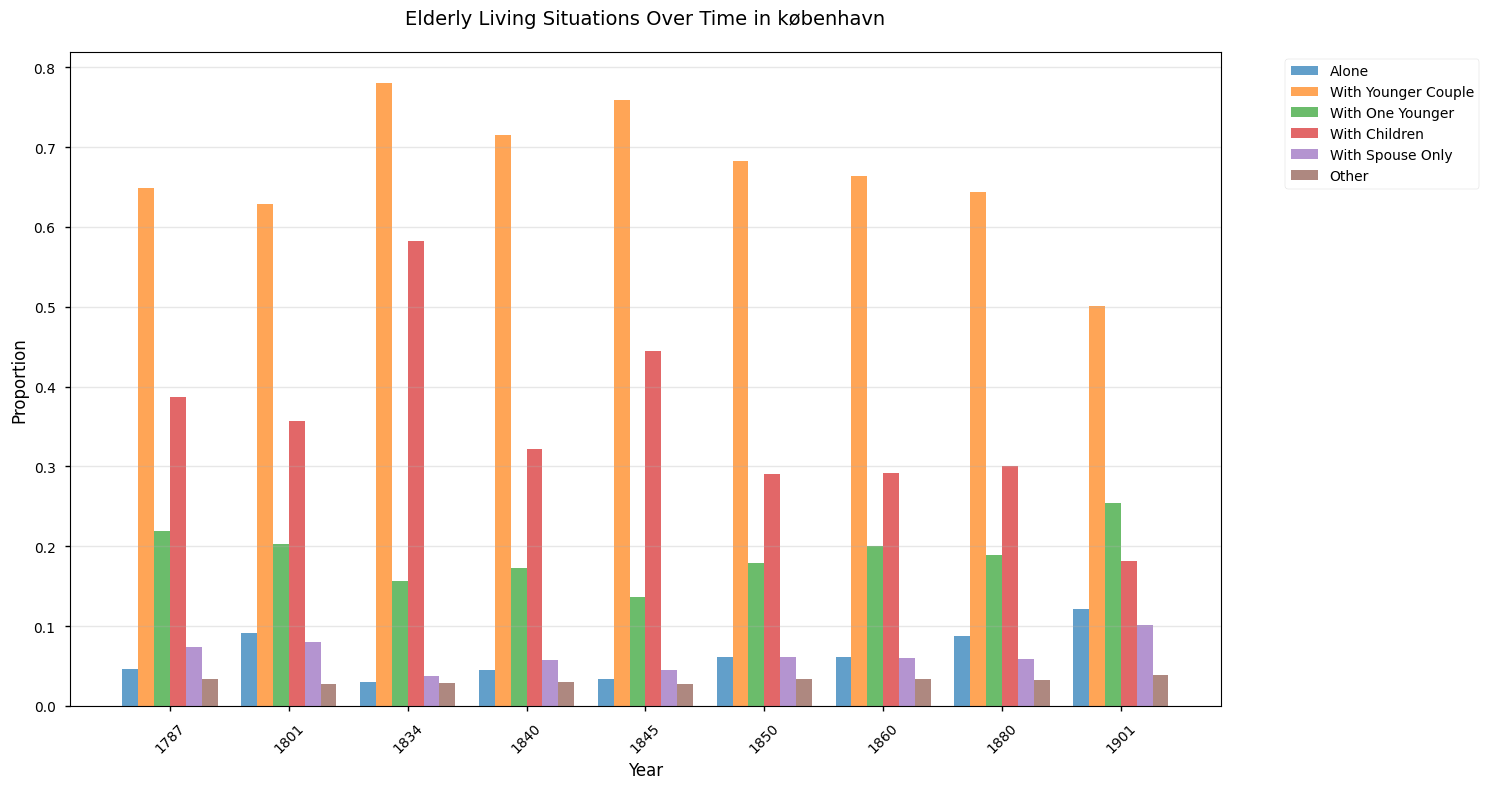

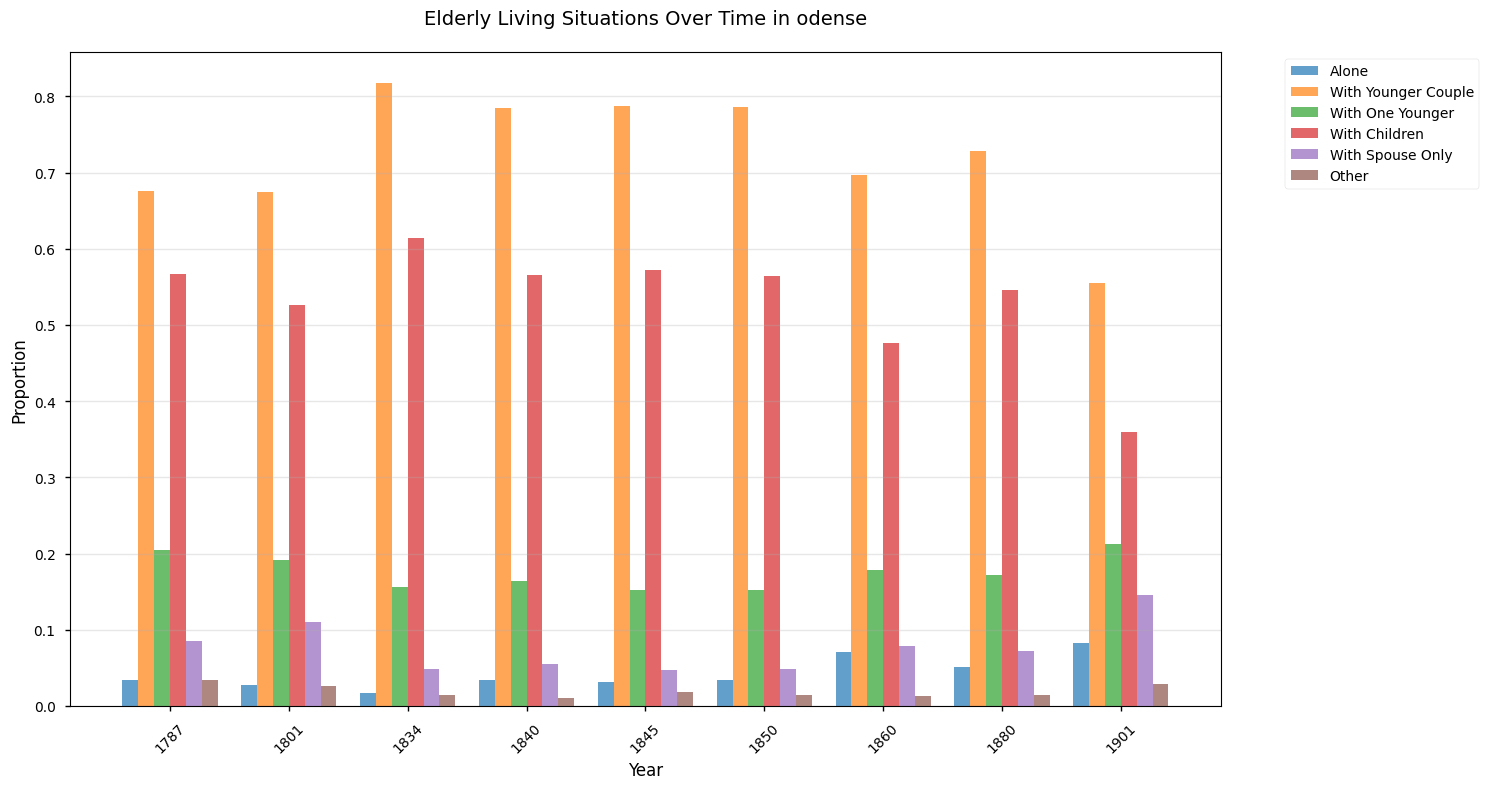

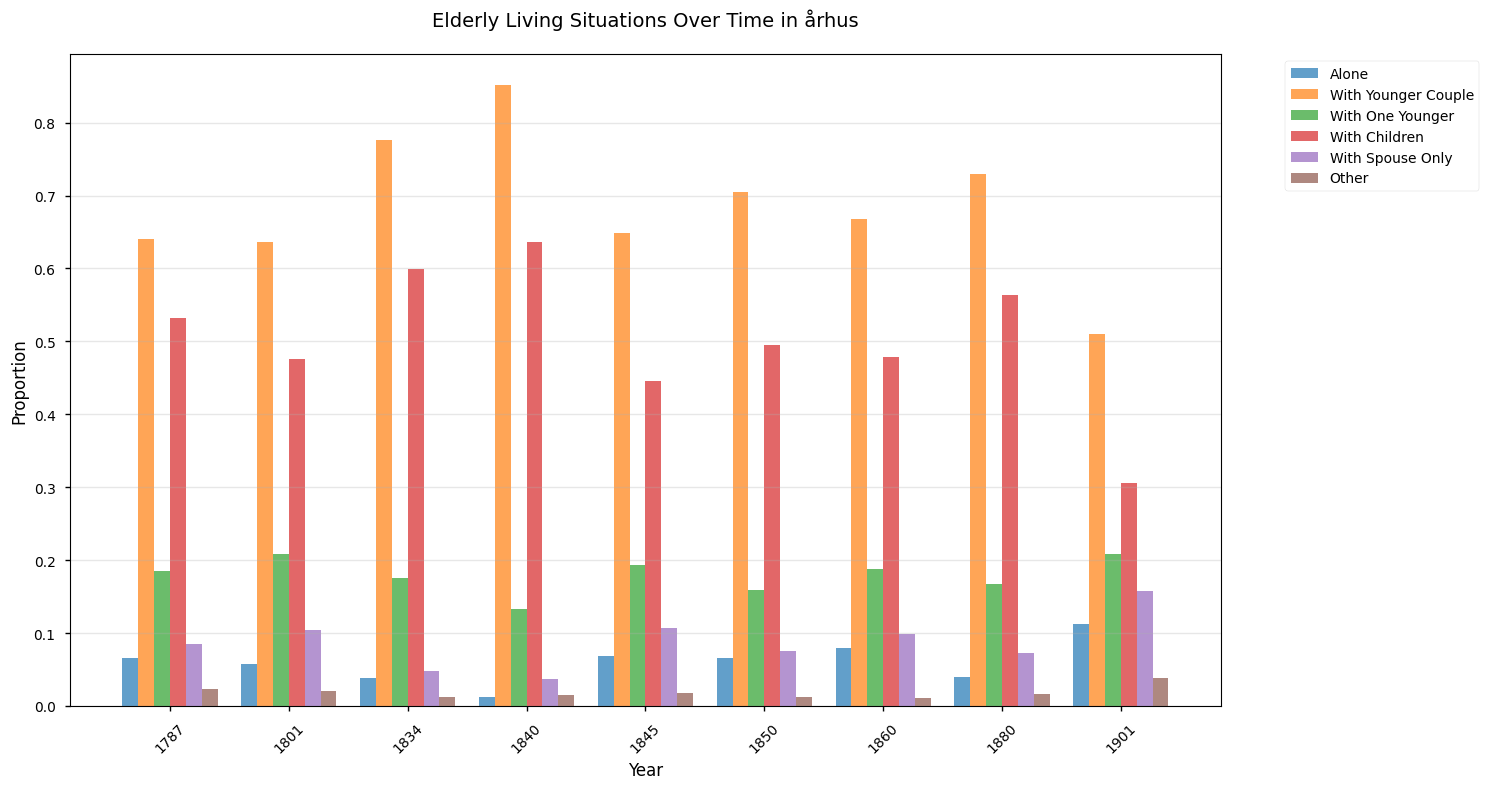

/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_72812/2541332531.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temporal_widow_props = elderly_df.groupby(


KeyError: 'Columns not found: False, True'

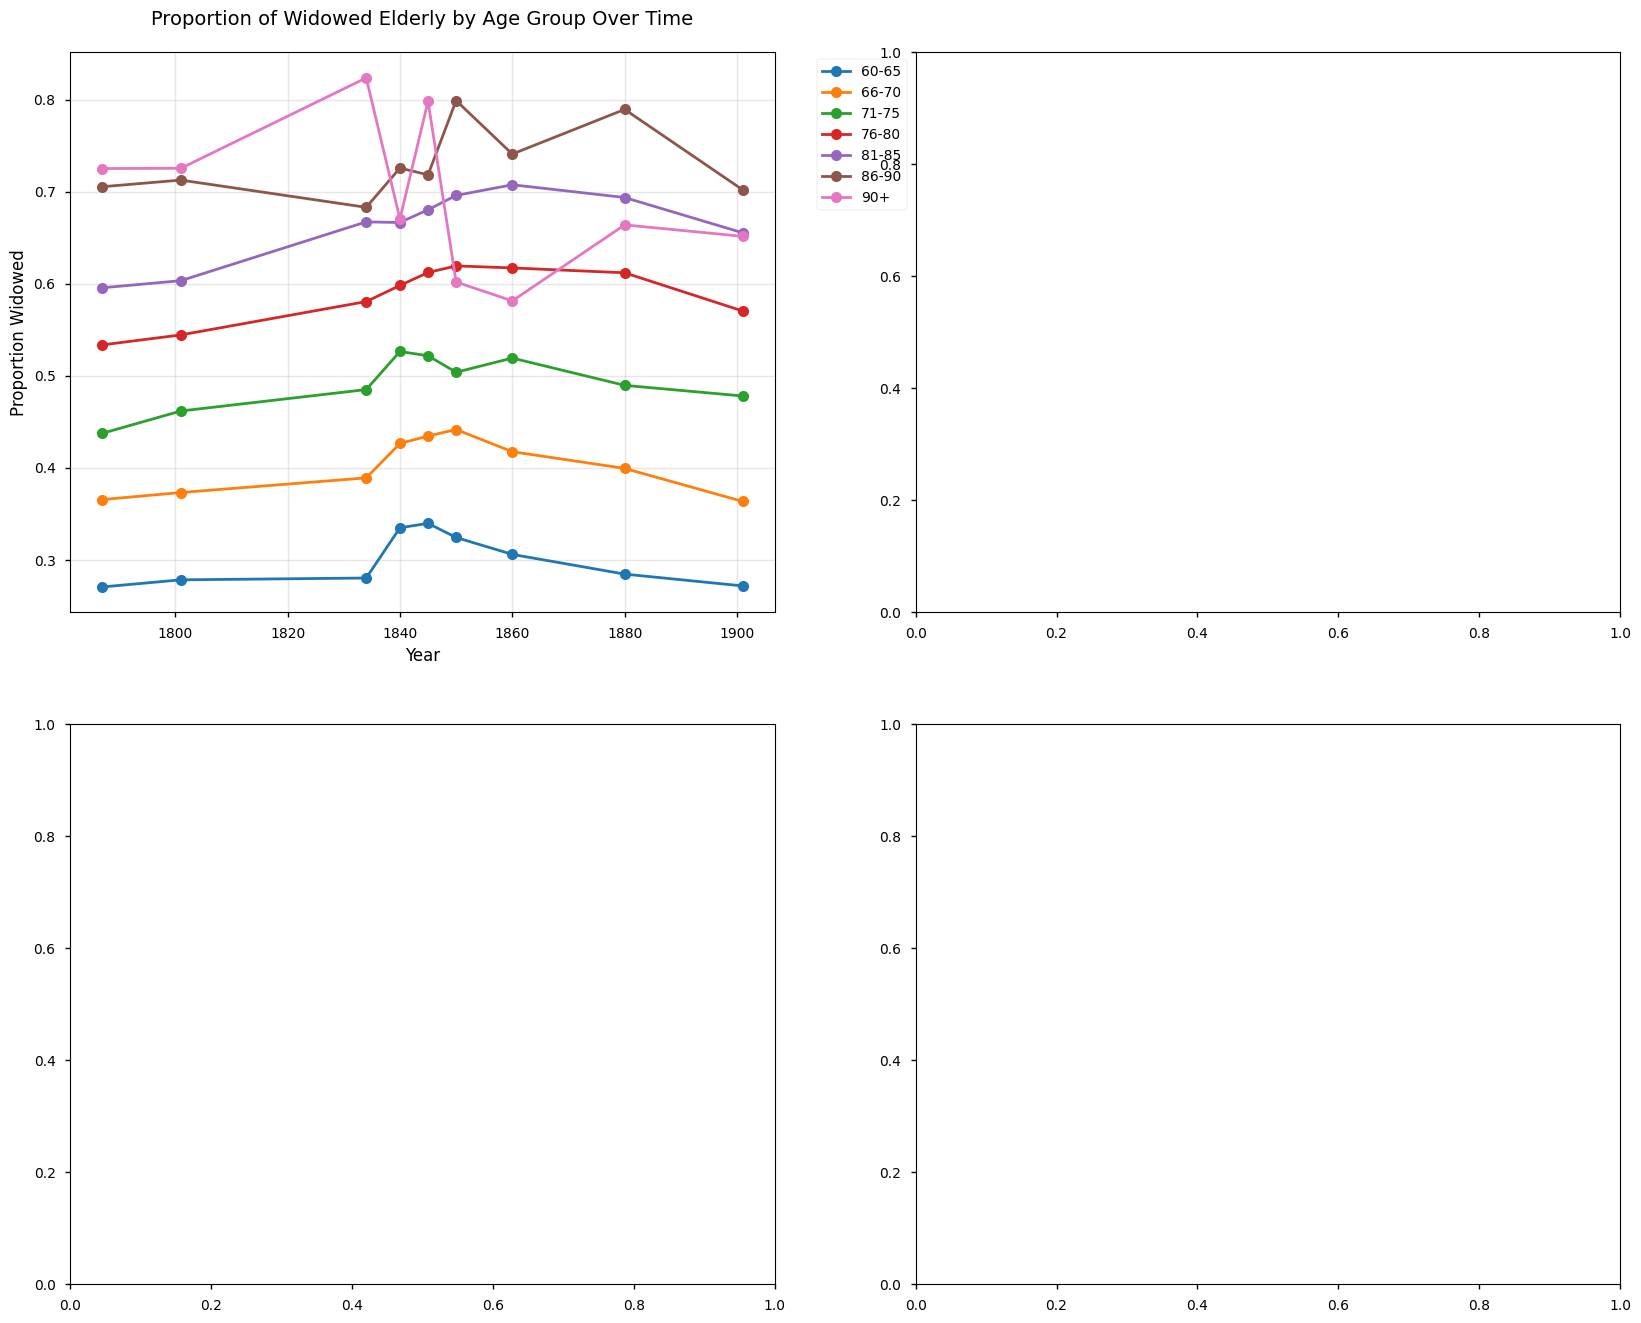

In [9]:
def create_temporal_analysis(elderly_df: pd.DataFrame) -> None:
    """
    Creates detailed visualizations of elderly living situations over time,
    broken down by county and including widow/widower analysis.
    
    Args:
        elderly_df: DataFrame containing elderly analysis results
    """
    # Create age groups for more meaningful analysis
    elderly_df['age_group'] = pd.cut(
        elderly_df['age'],
        bins=[59, 65, 70, 75, 80, 85, 90, 120],
        labels=['60-65', '66-70', '71-75', '76-80', '81-85', '86-90', '90+']
    )
    
    # Set the correct style
    plt.style.use('seaborn-v0_8-notebook')
    
    # First set of visualizations: Living situations over time by county
    situation_cols = ['alone', 'with_younger_couple', 'with_one_younger',
                     'with_children', 'with_spouse_only', 'other']
    
    # Create a figure for each county to improve readability
    for county in sorted(elderly_df['event_county'].unique()):
        county_data = elderly_df[elderly_df['event_county'] == county]
        
        # Calculate proportions for each year
        yearly_props = county_data.groupby('event_year')[situation_cols].mean()
        
        # Create bar plot with years slightly offset for each situation
        fig, ax = plt.subplots(figsize=(15, 8))
        
        years = yearly_props.index
        bar_width = 0.8 / len(situation_cols)  # Adjust width based on number of situations
        
        for idx, situation in enumerate(situation_cols):
            position = np.arange(len(years)) + idx * bar_width
            ax.bar(position, 
                  yearly_props[situation],
                  bar_width,
                  label=situation.replace('_', ' ').title(),
                  alpha=0.7)
        
        # Customize the plot
        ax.set_title(f'Elderly Living Situations Over Time in {county}',
                    pad=20, size=14)
        ax.set_xlabel('Year', size=12)
        ax.set_ylabel('Proportion', size=12)
        
        # Set x-axis ticks to show all years
        ax.set_xticks(np.arange(len(years)) + (len(situation_cols) - 1) * bar_width / 2)
        ax.set_xticklabels(years, rotation=45)
        
        # Add legend in a good position
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Add grid for better readability
        ax.grid(True, axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    # Second set of visualizations: Widow/widower analysis
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    
    # First create the widowed indicator as before
    widowed = elderly_df['marital_status'].str.contains('enke',
                                                    case=False,
                                                    na=False)

    # Convert the boolean series to numeric values
    elderly_df['widowed_numeric'] = widowed.astype(int)

    # Now we can properly group and calculate the mean
    temporal_widow_props = elderly_df.groupby(
        ['event_year', 'age_group']
    )['widowed_numeric'].mean().unstack()
    
    # Plot with markers and lines for better visibility
    for column in temporal_widow_props.columns:
        ax1.plot(temporal_widow_props.index, 
                temporal_widow_props[column],
                marker='o',
                label=column,
                linewidth=2,
                markersize=8)
    
    ax1.set_title('Proportion of Widowed Elderly by Age Group Over Time',
                  pad=20, size=14)
    ax1.set_xlabel('Year', size=12)
    ax1.set_ylabel('Proportion Widowed', size=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 2. County-specific widow/widower proportions over time
    for county in elderly_df['event_county'].unique():
        county_data = elderly_df[elderly_df['event_county'] == county]
        props = county_data.groupby('event_year')[widowed].mean()
        ax2.plot(props.index, props.values,
                marker='o',
                label=county,
                linewidth=2,
                markersize=8)
    
    ax2.set_title('Proportion of Widowed Elderly Over Time by County',
                  pad=20, size=14)
    ax2.set_xlabel('Year', size=12)
    ax2.set_ylabel('Proportion Widowed', size=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 3. Age distribution of widowed population over time as bar plot
    widow_age_dist = elderly_df[widowed].groupby(
        ['event_year', 'age_group']
    ).size().unstack(fill_value=0)
    
    # Convert to proportions
    widow_age_dist = widow_age_dist.div(widow_age_dist.sum(axis=1),
                                      axis=0)
    
    # Create bar plot for age distribution
    bar_width = 0.8 / len(widow_age_dist.columns)
    for idx, age_group in enumerate(widow_age_dist.columns):
        position = np.arange(len(widow_age_dist.index)) + idx * bar_width
        ax3.bar(position,
                widow_age_dist[age_group],
                bar_width,
                label=age_group,
                alpha=0.7)
    
    ax3.set_title('Age Distribution of Widowed Population Over Time',
                  pad=20, size=14)
    ax3.set_xlabel('Year', size=12)
    ax3.set_ylabel('Proportion of Widowed Population', size=12)
    ax3.set_xticks(np.arange(len(widow_age_dist.index)) + 
                   (len(widow_age_dist.columns) - 1) * bar_width / 2)
    ax3.set_xticklabels(widow_age_dist.index, rotation=45)
    ax3.grid(True, alpha=0.3)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 4. Widow proportion by age group
    sns.boxplot(
        data=elderly_df,
        x='age_group',
        y=widowed,
        ax=ax4
    )
    ax4.set_title('Widow/Widower Proportion by Age Group',
                  pad=20, size=14)
    ax4.set_xlabel('Age Group', size=12)
    ax4.set_ylabel('Proportion Widowed', size=12)
    ax4.grid(True, alpha=0.3)
    plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

    # Print summary statistics (same as before)
    print("\nTemporal Analysis Summary:")
    print("-" * 50)
    
    early_years = elderly_df['event_year'].min()
    late_years = elderly_df['event_year'].max()
    
    print(f"\nChanges in Living Situations ({early_years} vs {late_years}):")
    for county in elderly_df['event_county'].unique():
        print(f"\n{county.title()}:")
        early_data = elderly_df[
            (elderly_df['event_county'] == county) &
            (elderly_df['event_year'] == early_years)
        ][situation_cols].mean()
        
        late_data = elderly_df[
            (elderly_df['event_county'] == county) &
            (elderly_df['event_year'] == late_years)
        ][situation_cols].mean()
        
        for situation in situation_cols:
            change = late_data[situation] - early_data[situation]
            print(f"{situation.replace('_', ' ').title():20s}: "
                  f"{change:+.1%} change")

# Run the temporal analysis
create_temporal_analysis(elderly_df)